In [ ]:
import torchvision

torchvision.datasets.FashionMNIST('./', download=True)

100%|██████████| 26.4M/26.4M [03:21<00:00, 131kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 142kB/s]
100%|██████████| 4.42M/4.42M [00:29<00:00, 151kB/s] 
100%|██████████| 5.15k/5.15k [00:00<00:00, 3.89MB/s]


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [63]:
import torch.nn as nn
import torch.optim as optim


class Fnn(nn.Module):
    def __init__(self, dropout=None, batch_norm=False):
        super(Fnn, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(1)

        self.dropout = dropout is not None
        if self.dropout:
            self.do1 = nn.Dropout(dropout)
            self.do2 = nn.Dropout(dropout)

        self.batch_norm = batch_norm
        if batch_norm:
            self.bn1 = nn.BatchNorm1d(256)
            self.bn2 = nn.BatchNorm1d(128)
    
    def forward(self, x):
        x = x.view(-1, 784)

        x = self.fc1(x)
        if self.batch_norm:
            x = self.bn1(x)
            
        x = torch.relu(x)
        if self.dropout:
            x = self.do1(x)

        x = self.fc2(x)
        if self.batch_norm:
            x = self.bn2(x)

        x = torch.relu(x)
        if self.dropout:
            x = self.do2(x)

        x = self.fc3(x)
        return self.softmax(x)


def eval_model(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        correct = 0
        total = 0
        avg_loss = 0
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            avg_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # print(f'Accuracy: {100 * correct / total:.2f}%')
    
        return 100 * correct / total, avg_loss / len(test_loader)


def train(model, criterion, optimizer, train_loader, test_loader, num_epochs=5):
    train_accs = []
    train_losses = []
    total = train_loader.batch_size * len(train_loader)
    correct = 0

    test_accs = []
    test_losses = []
    for epoch in range(num_epochs):
        train_losses.append(0)
        correct = 0
        for images, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            train_losses[-1] += loss.item()

            predicted = torch.argmax(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()

        train_losses[-1] /= len(train_loader)
        train_accs.append(100 * correct / total)

        eval_acc, eval_loss = eval_model(model, test_loader)
        test_accs.append(eval_acc)
        test_losses.append(eval_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train accuracy: {train_accs[-1]:.2f}%, Train loss: {train_losses[-1]:.4f}', end=', ')
        print(f'Test accuracy: {eval_acc:.2f}%, Test loss: {eval_loss:.4f}')
    
    return train_accs, train_losses, test_accs, test_losses


### Число эпох

In [49]:
model1 = Fnn()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
train_accs1, train_losses1, test_accs1, test_losses1 = train(model1, criterion, optimizer, train_loader, test_loader, 7)

model2 = Fnn()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
train_accs2, train_losses2, test_accs2, test_losses2 = train(model2, criterion, optimizer, train_loader, test_loader, 35)

Epoch [1/7], Train accuracy: 76.69%, Train loss: 1.6978, Test accuracy: 79.57%, Test loss: 1.6669
Epoch [2/7], Train accuracy: 81.51%, Train loss: 1.6450, Test accuracy: 81.28%, Test loss: 1.6477
Epoch [3/7], Train accuracy: 83.55%, Train loss: 1.6248, Test accuracy: 83.06%, Test loss: 1.6296
Epoch [4/7], Train accuracy: 84.26%, Train loss: 1.6178, Test accuracy: 83.21%, Test loss: 1.6290
Epoch [5/7], Train accuracy: 84.87%, Train loss: 1.6117, Test accuracy: 83.76%, Test loss: 1.6236
Epoch [6/7], Train accuracy: 85.02%, Train loss: 1.6103, Test accuracy: 84.10%, Test loss: 1.6197
Epoch [7/7], Train accuracy: 85.14%, Train loss: 1.6087, Test accuracy: 84.46%, Test loss: 1.6156
Epoch [1/35], Train accuracy: 79.01%, Train loss: 1.6762, Test accuracy: 81.86%, Test loss: 1.6425
Epoch [2/35], Train accuracy: 83.35%, Train loss: 1.6274, Test accuracy: 82.54%, Test loss: 1.6352
Epoch [3/35], Train accuracy: 84.03%, Train loss: 1.6202, Test accuracy: 83.74%, Test loss: 1.6240
Epoch [4/35], Tra

In [45]:
import matplotlib.pyplot as plt


def show_curves(train_accs, train_losses, test_accs, test_losses, title=None):
    fig, ax = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    ax[0].plot(range(1, len(train_accs) + 1), train_accs, label='train')
    ax[0].plot(range(1, len(test_accs) + 1), test_accs, label='test')
    ax[0].set_title("Accuracy, %")
    ax[0].legend()

    ax[1].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    ax[1].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    ax[1].set_title("Loss")
    ax[1].legend()

    if title:
        fig.suptitle(title)

    plt.show()

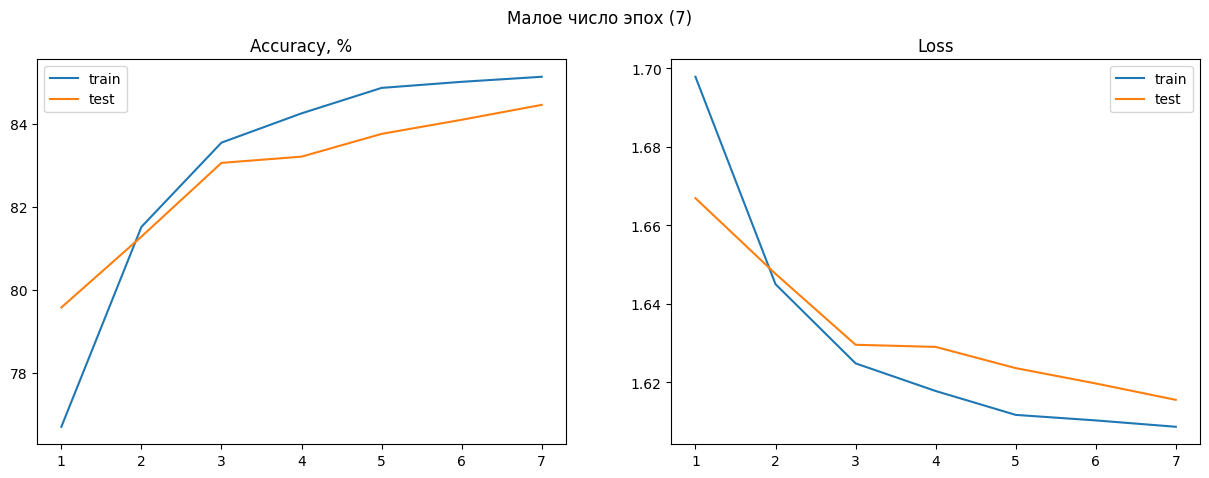

In [50]:
show_curves(train_accs1, train_losses1, test_accs1, test_losses1, "Малое число эпох (7)")

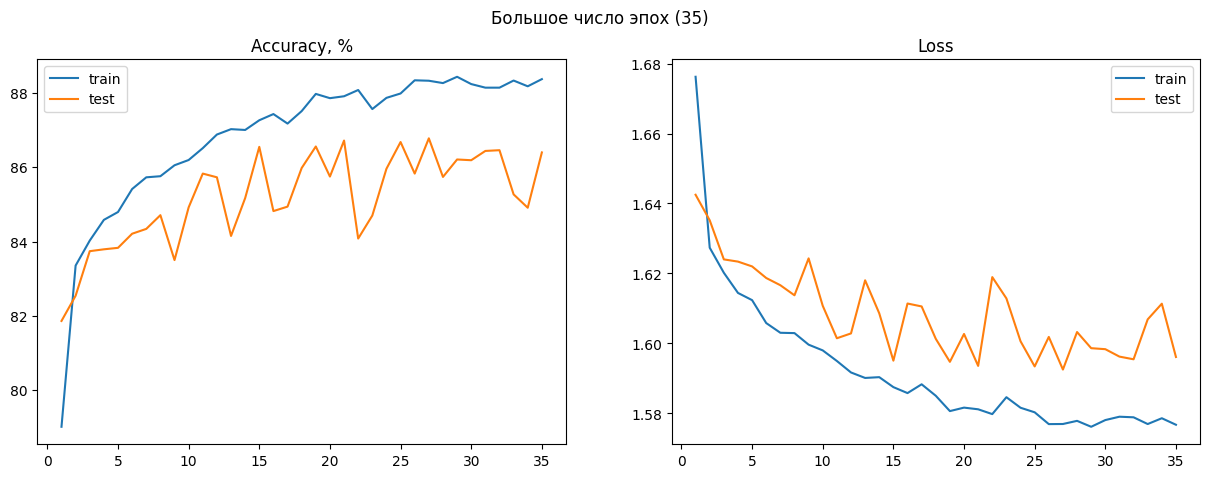

In [51]:
show_curves(train_accs2, train_losses2, test_accs2, test_losses2, "Большое число эпох (35)")

### Learning rate

In [42]:
model1 = Fnn()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.5)
train_accs1, train_losses1, test_accs1, test_losses1 = train(model1, criterion, optimizer, train_loader, test_loader, 35)

model2 = Fnn()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-6)
train_accs2, train_losses2, test_accs2, test_losses2 = train(model2, criterion, optimizer, train_loader, test_loader, 35)

Epoch [1/35], Train accuracy: 19.66%, Train loss: 2.2644, Test accuracy: 10.00%, Test loss: 2.3613
Epoch [2/35], Train accuracy: 9.99%, Train loss: 2.3611, Test accuracy: 10.00%, Test loss: 2.3613
Epoch [3/35], Train accuracy: 9.99%, Train loss: 2.3612, Test accuracy: 10.00%, Test loss: 2.3613
Epoch [4/35], Train accuracy: 9.99%, Train loss: 2.3611, Test accuracy: 10.00%, Test loss: 2.3613
Epoch [5/35], Train accuracy: 9.99%, Train loss: 2.3612, Test accuracy: 10.00%, Test loss: 2.3613
Epoch [6/35], Train accuracy: 9.99%, Train loss: 2.3611, Test accuracy: 10.00%, Test loss: 2.3613
Epoch [7/35], Train accuracy: 9.99%, Train loss: 2.3612, Test accuracy: 10.00%, Test loss: 2.3613
Epoch [8/35], Train accuracy: 9.99%, Train loss: 2.3612, Test accuracy: 10.00%, Test loss: 2.3613
Epoch [9/35], Train accuracy: 9.99%, Train loss: 2.3612, Test accuracy: 10.00%, Test loss: 2.3613
Epoch [10/35], Train accuracy: 9.99%, Train loss: 2.3612, Test accuracy: 10.00%, Test loss: 2.3613
Epoch [11/35], Tra

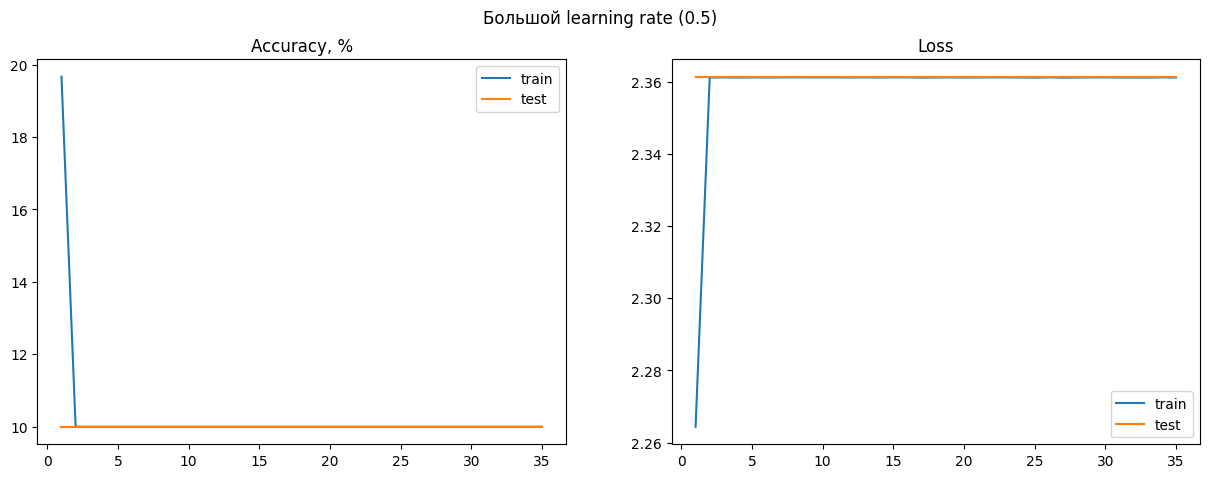

In [46]:
show_curves(train_accs1, train_losses1, test_accs1, test_losses1, "Большой learning rate (0.5)")

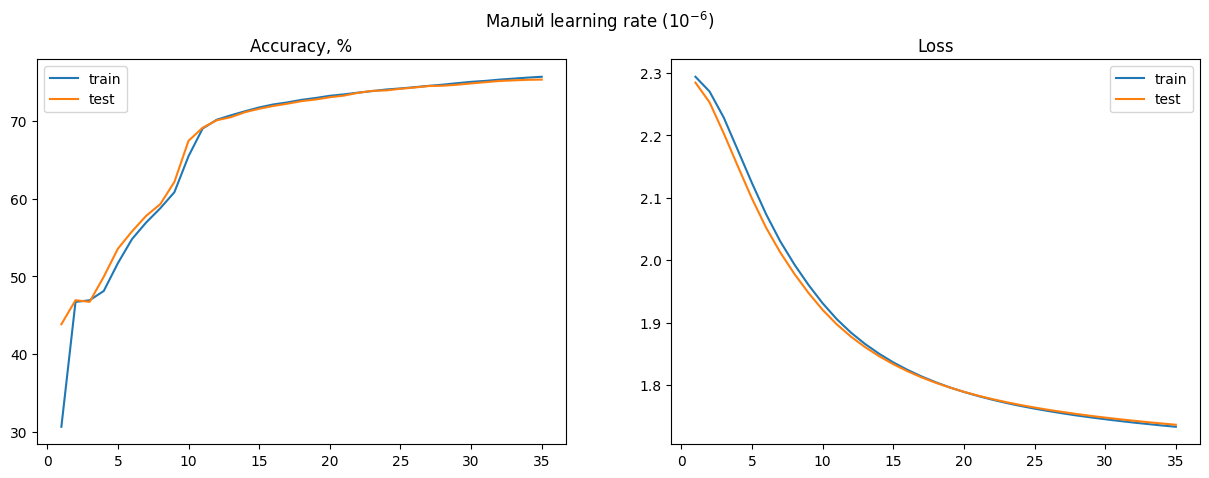

In [48]:
show_curves(train_accs2, train_losses2, test_accs2, test_losses2, "Малый learning rate ($10^{-6}$)")

### Dropout

In [52]:
model1 = Fnn(dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
train_accs1, train_losses1, test_accs1, test_losses1 = train(model1, criterion, optimizer, train_loader, test_loader, 35)

model2 = Fnn()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
train_accs2, train_losses2, test_accs2, test_losses2 = train(model2, criterion, optimizer, train_loader, test_loader, 35)

Epoch [1/35], Train accuracy: 76.12%, Train loss: 1.7029, Test accuracy: 81.31%, Test loss: 1.6477
Epoch [2/35], Train accuracy: 82.61%, Train loss: 1.6343, Test accuracy: 82.30%, Test loss: 1.6374
Epoch [3/35], Train accuracy: 83.84%, Train loss: 1.6215, Test accuracy: 83.72%, Test loss: 1.6237
Epoch [4/35], Train accuracy: 84.71%, Train loss: 1.6134, Test accuracy: 84.31%, Test loss: 1.6174
Epoch [5/35], Train accuracy: 85.31%, Train loss: 1.6072, Test accuracy: 83.22%, Test loss: 1.6291
Epoch [6/35], Train accuracy: 85.55%, Train loss: 1.6050, Test accuracy: 85.05%, Test loss: 1.6102
Epoch [7/35], Train accuracy: 85.52%, Train loss: 1.6052, Test accuracy: 84.61%, Test loss: 1.6141
Epoch [8/35], Train accuracy: 86.21%, Train loss: 1.5986, Test accuracy: 84.33%, Test loss: 1.6167
Epoch [9/35], Train accuracy: 85.91%, Train loss: 1.6009, Test accuracy: 85.66%, Test loss: 1.6042
Epoch [10/35], Train accuracy: 86.44%, Train loss: 1.5960, Test accuracy: 84.61%, Test loss: 1.6130
Epoch [11

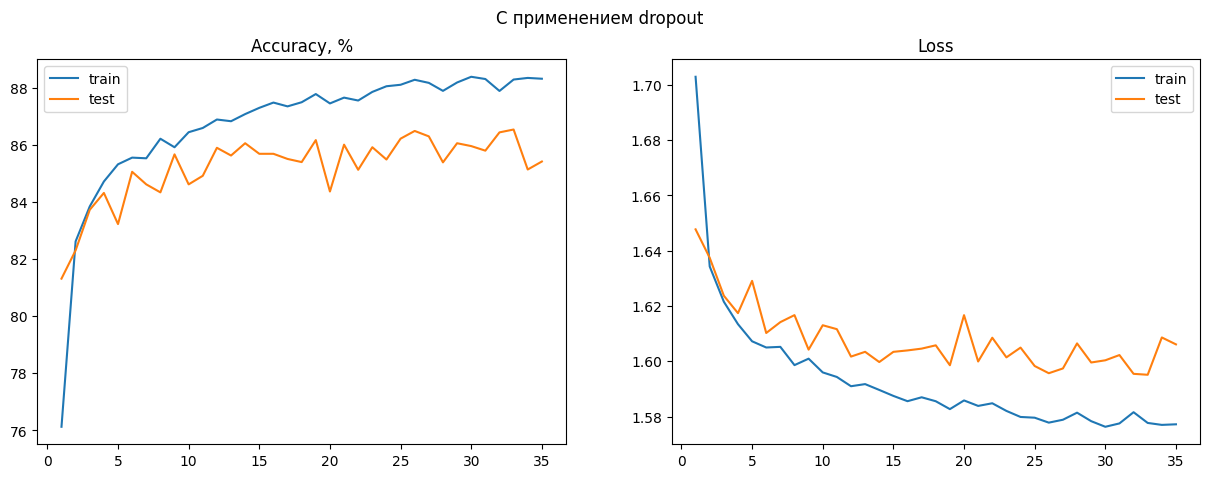

In [53]:
show_curves(train_accs1, train_losses1, test_accs1, test_losses1, "С применением dropout")

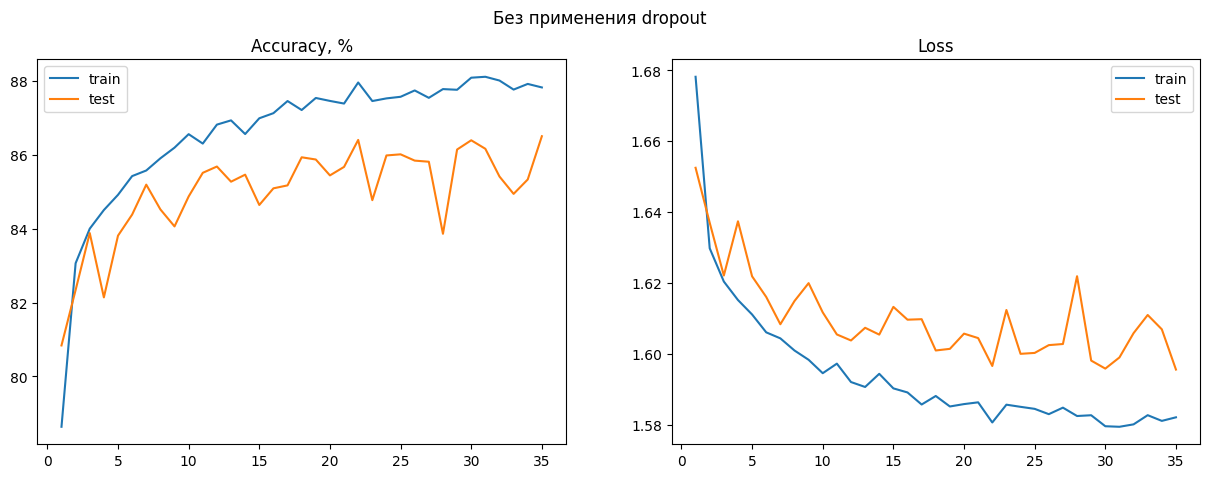

In [54]:
show_curves(train_accs2, train_losses2, test_accs2, test_losses2, "Без применения dropout")

### Нормализация батчей

In [64]:
model1 = Fnn(batch_norm=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
train_accs1, train_losses1, test_accs1, test_losses1 = train(model1, criterion, optimizer, train_loader, test_loader, 35)

model2 = Fnn()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
train_accs2, train_losses2, test_accs2, test_losses2 = train(model2, criterion, optimizer, train_loader, test_loader, 35)

Epoch [1/35], Train accuracy: 82.34%, Train loss: 1.6518, Test accuracy: 84.82%, Test loss: 1.6154
Epoch [2/35], Train accuracy: 82.97%, Train loss: 1.6314, Test accuracy: 83.11%, Test loss: 1.6278
Epoch [3/35], Train accuracy: 84.39%, Train loss: 1.6164, Test accuracy: 83.18%, Test loss: 1.6280
Epoch [4/35], Train accuracy: 85.08%, Train loss: 1.6094, Test accuracy: 84.83%, Test loss: 1.6130
Epoch [5/35], Train accuracy: 85.59%, Train loss: 1.6044, Test accuracy: 84.46%, Test loss: 1.6158
Epoch [6/35], Train accuracy: 85.80%, Train loss: 1.6022, Test accuracy: 85.88%, Test loss: 1.6015
Epoch [7/35], Train accuracy: 86.19%, Train loss: 1.5982, Test accuracy: 85.62%, Test loss: 1.6041
Epoch [8/35], Train accuracy: 86.34%, Train loss: 1.5966, Test accuracy: 84.06%, Test loss: 1.6199
Epoch [9/35], Train accuracy: 86.16%, Train loss: 1.5987, Test accuracy: 84.51%, Test loss: 1.6148
Epoch [10/35], Train accuracy: 86.87%, Train loss: 1.5919, Test accuracy: 84.23%, Test loss: 1.6181
Epoch [11

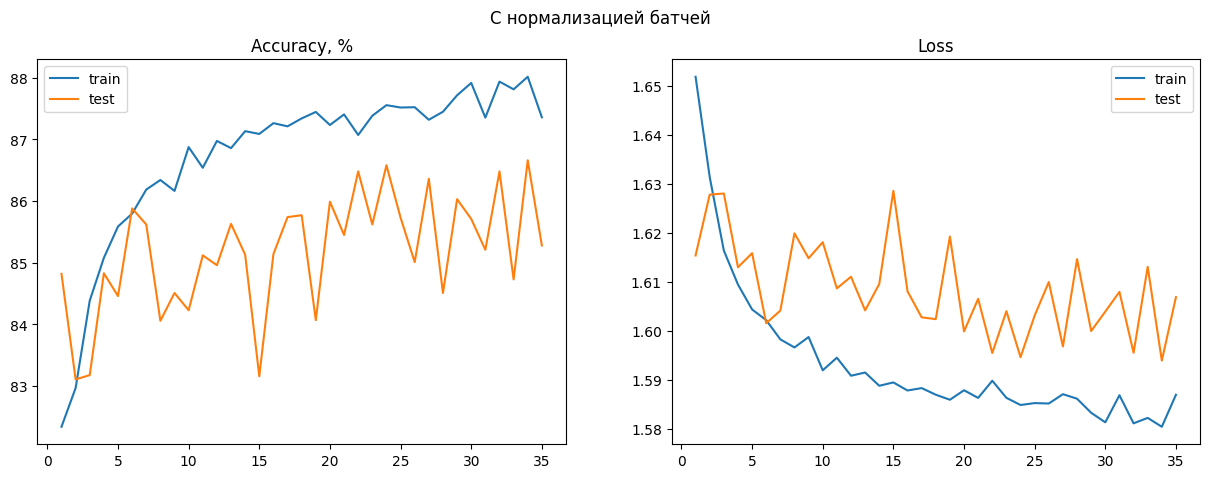

In [65]:
show_curves(train_accs1, train_losses1, test_accs1, test_losses1, "С нормализацией батчей")

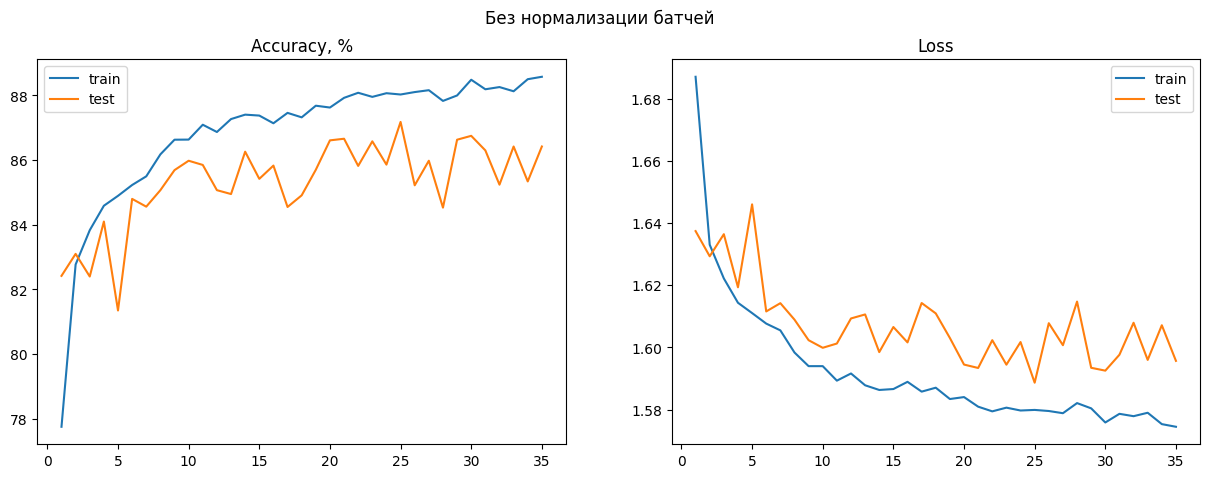

In [66]:
show_curves(train_accs2, train_losses2, test_accs2, test_losses2, "Без нормализации батчей")